# Capa límite con gradiente de presión: Falkner-Skan

## Ecuación de Falkner-Skan

En clases derivamos la ecuación de Falkner-Skan para el perfil de velocidad dentro de la capa límite sobre una placa plana con velocidad al infinito variable:

\begin{equation}
f'''+\frac{1}{2}ff''-\frac{m}{m+1}(f'^2-1)=0
\end{equation}

donde sabemos que

\begin{align}
f'(\eta) = \frac{u}{U_\infty}\\
\eta = y\sqrt{\frac{1+m}{\nu}\frac{U_\infty}{x}}
\end{align}

y las condiciones de borde

\begin{align}
f'(0) = 0\\
f'(\infty) = 1\\
f(0) = 0
\end{align}

En $\eta$, la coordenada $x$ corre paralela a la placa plana e $y$ perpendicular a esta.


## Flujo contra una pared en ángulo

El flujo potencial sobre una cuña tiene la siguiente solución

\begin{equation}
\psi(r,\theta) = C_0 r^{m+1}\sin\left[(m+1)\theta\right]
\end{equation}

y lo cual da una velocidad

\begin{align}
v_r = \frac{1}{r}\frac{\partial\psi}{\partial\theta} = C_0 r^m(m+1)\cos[(m+1)\theta] \nonumber\\
v_\theta = -\frac{\partial\psi}{\partial r} = -C_0 r^m(m+1)\sin[(m+1)\theta]
\end{align}

que varía como $\sim r^m$ para un ángulo $\theta$ constante. Veamos como se ven las líneas de flujo.

In [57]:
import numpy
from math import pi
from matplotlib import pyplot
%matplotlib inline
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

nx = 50
L = 4.0
x = numpy.linspace(-L/2,L/2,nx)
X,Y = numpy.meshgrid(x,x)

U_inf = 1.
q = 5.

r     = numpy.sqrt(X**2+Y**2)
theta = numpy.arctan2(Y,X)

def psi_cuna(r,theta,m,C0):
    return C0*r**(m+1)*numpy.sin((m+1)*theta)

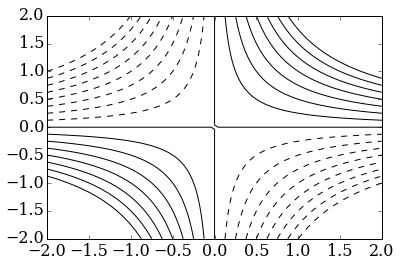

In [58]:
C0 = 1.
m  = 1.

psi = psi_cuna(r, theta, m, C0)

pyplot.figure()
contours = numpy.arange(-4,4,0.5)
C=pyplot.contour(X, Y, psi, contours, colors='k')

Como ven, el flujo depende de `m`. Para `m=1`, tenemos un flujo que choca con una pared. Veamos `m<1`

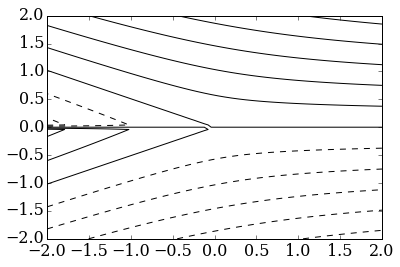

In [68]:
m  = 0.3/1.7

psi = psi_cuna(r, theta, m, C0)

pyplot.figure()
contours = numpy.arange(-4,4,0.5)
C=pyplot.contour(X, Y, psi, contours, colors='k')

Obtenemos el flujo contra una cuña. Finalmente veamos que pasa para `m>1`

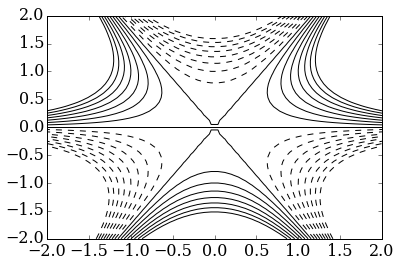

In [60]:
m  = 2.

psi = psi_cuna(r, theta, m, C0)

pyplot.figure()
contours = numpy.arange(-4,4,0.5)
C=pyplot.contour(X, Y, psi, contours, colors='k')

Obtenemos un flujo alrededor de paredes encontradas en el origen. Todos estos tienen la forma $U_\infty = Kr^m$, y por tanto su capa límite puede ser descrita con Falkner-Skan si consideramos el eje $x$ paralelo a $r$.

## Espesor de capa límite a partir de la ecuación de Falkner-Skan

Similar a Blasius, la derivación de Falkner-Skan nos dejó con una ecuación diferencial ordinaria de tercer orden, donde la función $f$ depende de solamente una variable ($\eta$). A continuación presentamos un pequeño código que integra la ecuación diferencial numéricamente (utilizando método de Euler de primer orden), para encontrar la solución para $f$, y, por ende, $f'$ y $u(y)$.

El método de Euler integra numéricamente de la siguiente manera

\begin{equation}
F^{n+1} = F^n + h F'^n
\end{equation}

Escribamos una función que haga la iteración de Euler

In [61]:
import numpy

def Euler_FS(F, N, h, m):
    for i in range(N):
        k1 = h * f_prima(F[i,:], m)
        F[i+1,:] = F[i,:] + k1
    
    return F

En este caso, $F$ será el vector

\begin{equation}
F = \left(
\begin{array}{c}
f\\
f'\\
f''\\
\end{array}
\right)
\end{equation}

por lo que $F'$ es

\begin{equation}
F' = \left(
\begin{array}{c}
f'\\
f''\\
f'''\\
\end{array}
\right)
\end{equation}

Pero por la ecuación de Falkner-Skan, podemos escribir $f'''=-\frac{1}{2}ff''+\frac{m}{m+1}(f'^2-1)$, y $F'$ queda

\begin{equation}
F' = \left(
\begin{array}{c}
f'\\
f''\\
-\frac{1}{2}ff''+\frac{m}{m+1}(f'^2-1)\\
\end{array}
\right)
\end{equation}

In [62]:
def f_prima(F,m):
    return numpy.array([F[1], F[2], -F[2]*F[0]/2 + m/(m+1)*(F[1]**2-1)])

La ecuación de Falkner-Skan es de tercer orden y tenemos tres condiciones de contorno, por lo que deberíamos ser capaces de resolver la ecuación, sin embargo, una de esas condiciones está situada al "final" de nuestra evaluación. Para resolver este problema numéricamente usaremos la técnica de *shooting*: buscar la condición de contorno en $f''(0)$ tal que se cumpla la condición $f'(\infty) = 1$. 

El punto $\eta\to\infty$ está lejos de la placa. Consideremos que $\eta=10$ ya está suficientemente lejos, y $f'(10)\approx1$.

### Caso 1: flujo contra una pared (`m=1`)

Con prueba y error (no muy eficiente!) llegamos a que la condición de contorno $f''(0)=0.871572$ cumple con $f'(10)\approx1$.

In [65]:
L = 10.
N = 1000000
n = 3

U_inf = 1.

a = 0
b = L
h = (b-a)/N

z = numpy.arange(a,b+h,h)
F = numpy.zeros((N+1, n))

m = 1.

F[0,:] = [0., 0., 0.871572] # Condicion de contorno
F = Euler_FS(F,N,h, m)

u = F[:,1]

print r'eta u'
for i in range(N+1):
    if (i%1000)==0:
        print '{0} {1}'.format(z[i], u[i])

eta u
0.0 0.0
0.01 0.00869074515758
0.02 0.017331492518
0.03 0.0259222477225
0.04 0.0344630201238
0.05 0.0429538227433
0.06 0.0513946722284
0.07 0.0597855888099
0.08 0.06812659626
0.09 0.0764177218499
0.1 0.0846589963086
0.11 0.0928504537808
0.12 0.100992131786
0.13 0.109084071178
0.14 0.117126316102
0.15 0.125118913957
0.16 0.133061915353
0.17 0.140955374073
0.18 0.148799347031
0.19 0.156593894233
0.2 0.164339078739
0.21 0.172034966622
0.22 0.179681626929
0.23 0.187279131645
0.24 0.194827555652
0.25 0.202326976688
0.26 0.209777475316
0.27 0.21717913488
0.28 0.224532041471
0.29 0.231836283886
0.3 0.239091953595
0.31 0.2462991447
0.32 0.253457953902
0.33 0.260568480461
0.34 0.267630826162
0.35 0.274645095277
0.36 0.281611394531
0.37 0.288529833065
0.38 0.295400522402
0.39 0.302223576408
0.4 0.308999111262
0.41 0.315727245416
0.42 0.322408099566
0.43 0.329041796613
0.44 0.335628461628
0.45 0.342168221823
0.46 0.348661206514
0.47 0.355107547086
0.48 0.361507376962
0.49 0.367860831569
0.5 

Fíjense que $f'(\eta)=u/U_\infty=0.99$ en $\eta=3.37$. Considerando que ese punto $y=\delta$ quedamos con 

\begin{equation}
\frac{\delta}{x}=\frac{3.37}{\left((m+1)\frac{U_\infty x}{\nu}\right)^{1/2}} = \frac{3.37}{\sqrt{2\cdot Re_x}} 
\end{equation}

### Caso 2: flujo sobre una cuña (`m=0.176`)

La condición de contorno $f''(0)=0.547838$ cumple con $f'(10)\approx1$.

In [70]:
z = numpy.arange(a,b+h,h)
F = numpy.zeros((N+1, n))

m = 0.3/1.7

F[0,:] = [0., 0., 0.547838] # Condicion de contorno
F = Euler_FS(F,N,h, m)

u = F[:,1]

print r'eta u'
for i in range(N+1):
    if (i%1000)==0:
        print '{0} {1}'.format(z[i], u[i])

eta u
0.0 0.0
0.01 0.00547088747529
0.02 0.010926774604
0.03 0.0163676604984
0.04 0.0217935436885
0.05 0.027204422131
0.06 0.0326002932184
0.07 0.0379811537876
0.08 0.0433470001294
0.09 0.0486978279968
0.1 0.0540336326144
0.11 0.0593544086869
0.12 0.0646601504079
0.13 0.0699508514693
0.14 0.0752265050695
0.15 0.0804871039227
0.16 0.0857326402673
0.17 0.0909631058749
0.18 0.0961784920593
0.19 0.101378789685
0.2 0.106563989176
0.21 0.111734080524
0.22 0.116889053299
0.23 0.122028896656
0.24 0.127153599344
0.25 0.132263149718
0.26 0.137357535742
0.27 0.142436745001
0.28 0.147500764713
0.29 0.152549581729
0.3 0.157583182552
0.31 0.162601553337
0.32 0.167604679906
0.33 0.172592547753
0.34 0.177565142053
0.35 0.182522447674
0.36 0.187464449182
0.37 0.19239113085
0.38 0.19730247667
0.39 0.202198470358
0.4 0.207079095364
0.41 0.211944334882
0.42 0.216794171858
0.43 0.221628588997
0.44 0.226447568774
0.45 0.231251093441
0.46 0.236039145038
0.47 0.240811705399
0.48 0.245568756162
0.49 0.25031027

$f'(\eta)=0.99$ ocurre en $\eta=4.2$, por lo tanto, en este caso

\begin{equation}
\frac{\delta}{x}=\frac{4.2}{\left((m+1)\frac{U_\infty x}{\nu}\right)^{1/2}} = \frac{3.37}{\sqrt{1.176\cdot Re_x}} 
\end{equation}